# Two-Image Alignment with **Custom Homography (DLT + RANSAC)**

This notebook aligns and stitches **two images** using:
- DoG+Harris keypoints
- ORB descriptors at those keypoints
- Descriptor matching (BF + ratio test)
- **Custom Homography** estimation (**Normalized DLT + RANSAC**) – *no `cv2.findHomography`*
- Warping image 2 → image 1 and saving outputs

Outputs are saved to `./customH2_outputs/`.

In [1]:
# !pip install opencv-python numpy matplotlib
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

ROOT_DIR = 'D:/Teach_n_Train/Advanced_Lessons_CV/LABS/Image_Matching_harris/'

OUT_DIR = Path(ROOT_DIR + 'customH2_outputs'); OUT_DIR.mkdir(parents=True, exist_ok=True)
print('Output dir:', OUT_DIR.resolve())

# ---------- Params ----------
SIGMA0 = 1.6
SCALES_PER_OCT = 3
NUM_OCTAVES = 4
CONTRAST_TH = 0.03
EDGE_R = 10
HARRIS_K = 0.04
HARRIS_REL_TH = 0.01
NMS_RADIUS = 3
DRAW_SIZE = 3

Output dir: D:\Teach_n_Train\Advanced_Lessons_CV\LABS\Image_Matching_harris\customH2_outputs


In [2]:
def gaussian_blur(img, sigma):
    ksize = max(3, int(np.ceil(sigma*6))|1)
    return cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)

def build_gaussian_pyramid(gray, num_octaves=NUM_OCTAVES, s=SCALES_PER_OCT, sigma0=SIGMA0):
    base = gray.astype(np.float32) / 255.0
    k = 2 ** (1.0 / s)
    gauss_pyr, sigmas_pyr = [], []
    for o in range(num_octaves):
        octave_imgs, octave_sigmas = [], []
        sigmas = [sigma0 * (k**i) for i in range(s + 3)]
        if o == 0:
            prev = gaussian_blur(base, np.sqrt(max(sigmas[0]**2 - 0.5**2, 1e-6)))
        else:
            prev = cv2.resize(gauss_pyr[o-1][s], (base.shape[1] >> o, base.shape[0] >> o), interpolation=cv2.INTER_NEAREST)
        octave_imgs.append(prev); octave_sigmas.append(sigmas[0])
        for i in range(1, s+3):
            sigma_prev, sigma_curr = sigmas[i-1], sigmas[i]
            sigma_inc = np.sqrt(max(sigma_curr**2 - sigma_prev**2, 1e-6))
            blur = gaussian_blur(octave_imgs[-1], sigma_inc)
            octave_imgs.append(blur); octave_sigmas.append(sigmas[i])
        gauss_pyr.append(octave_imgs); sigmas_pyr.append(octave_sigmas)
    return gauss_pyr, sigmas_pyr

def build_dog_pyramid(gauss_pyr):
    dog_pyr = []
    for octave_imgs in gauss_pyr:
        dogs = [octave_imgs[i] - octave_imgs[i-1] for i in range(1, len(octave_imgs))]
        dog_pyr.append(dogs)
    return dog_pyr

def is_local_extrema(cube):
    c = cube[1,1,1]
    if c > 0:
        return c == cube.max()
    else:
        return c == cube.min()

def pass_edge_response(dog, y, x, r=EDGE_R):
    Dxx = dog[y, x+1] + dog[y, x-1] - 2*dog[y, x]
    Dyy = dog[y+1, x] + dog[y-1, x] - 2*dog[y, x]
    Dxy = (dog[y+1, x+1] - dog[y+1, x-1] - dog[y-1, x+1] + dog[y-1, x-1]) * 0.25
    Tr = Dxx + Dyy
    Det = Dxx*Dyy - Dxy*Dxy
    if Det <= 0:
        return False
    ratio = (Tr*Tr) / Det
    rcrit = ((r + 1.0)**2) / r
    return ratio < rcrit

def harris_response(img, k=HARRIS_K, win_sigma=1.0):
    Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_REPLICATE)
    Ixx, Iyy, Ixy = Ix*Ix, Iy*Iy, Ix*Iy
    Sxx = gaussian_blur(Ixx, win_sigma)
    Syy = gaussian_blur(Iyy, win_sigma)
    Sxy = gaussian_blur(Ixy, win_sigma)
    detM = Sxx*Syy - Sxy*Sxy
    traceM = Sxx + Syy
    R = detM - k*(traceM**2)
    return R

def nonmax_suppression(points, radius):
    if not points:
        return []
    pts = np.array(points)
    order = np.argsort(-pts[:,2])
    kept, taken = [], np.zeros(len(points), dtype=bool)
    for i in order:
        if taken[i]:
            continue
        yi, xi, _ = pts[i]
        kept.append(points[i])
        dy = pts[:,0] - yi
        dx = pts[:,1] - xi
        mask = (dx*dx + dy*dy) <= (radius*radius)
        taken = taken | mask
    return kept

def detect_keypoints_dog_harris(gray,
                                num_octaves=NUM_OCTAVES,
                                s=SCALES_PER_OCT,
                                sigma0=SIGMA0,
                                contrast_th=CONTRAST_TH,
                                edge_r=EDGE_R,
                                harris_k=HARRIS_K,
                                harris_rel_th=HARRIS_REL_TH,
                                nms_radius=NMS_RADIUS):
    gauss_pyr, _ = build_gaussian_pyramid(gray, num_octaves, s, sigma0)
    dog_pyr = build_dog_pyramid(gauss_pyr)
    from collections import defaultdict
    buckets = defaultdict(list)
    for o in range(num_octaves):
        dogs = dog_pyr[o]
        gaussians = gauss_pyr[o]
        H, W = dogs[0].shape
        harris_list = []
        for gi in range(1, s+2):
            R = harris_response(gaussians[gi], k=harris_k, win_sigma=1.0)
            Rmax = float(np.max(R)) if R.size else 1.0
            thr = harris_rel_th * (Rmax if Rmax > 1e-12 else 1.0)
            harris_list.append((R, thr))
        for i in range(1, s+1):
            dog_prev, dog_curr, dog_next = dogs[i-1], dogs[i], dogs[i+1]
            R, R_thr = harris_list[i-1]
            for y in range(1, H-1):
                for x in range(1, W-1):
                    val = dog_curr[y, x]
                    if abs(val) < contrast_th:
                        continue
                    cube = np.stack([
                        dog_prev[y-1:y+2, x-1:x+2],
                        dog_curr[y-1:y+2, x-1:x+2],
                        dog_next[y-1:y+2, x-1:x+2]
                    ], axis=0)
                    if not is_local_extrema(cube):
                        continue
                    if not pass_edge_response(dog_curr, y, x, r=edge_r):
                        continue
                    Rh = R[y, x]
                    if Rh <= R_thr:
                        continue
                    buckets[(o, i)].append((y, x, float(Rh)))
    final_points = []
    for (o, i), pts in buckets.items():
        kept = nonmax_suppression(pts, radius=nms_radius)
        scale_factor = (2 ** o)
        for (y, x, sc) in kept:
            x0 = int(x * scale_factor)
            y0 = int(y * scale_factor)
            sigma = SIGMA0 * (2 ** (o + i / float(SCALES_PER_OCT)))
            final_points.append({'x':x0,'y':y0,'octave':o,'scale_index':i,'sigma':float(sigma),'score':float(sc)})
    return final_points

def draw_keypoints(img_bgr, kps, color=(0,255,0)):
    out = img_bgr.copy()
    for kp in kps:
        cv2.circle(out, (int(kp['x']), int(kp['y'])), DRAW_SIZE, color, 1, lineType=cv2.LINE_AA)
    return out

In [4]:
def kps_to_cv2_keypoints(kps):
    cv_kps = []
    for kp in kps:
        size = max(3.0, float(kp['sigma']*2.0))
        cv_kps.append(cv2.KeyPoint(float(kp['x']), float(kp['y']), size))
    return cv_kps

def compute_orb_descriptors(gray, kps):
    orb = cv2.ORB_create(nfeatures=max(1500, len(kps)))
    cv_kps = kps_to_cv2_keypoints(kps)
    if len(cv_kps) == 0:
        return [], None
    cv_kps, desc = orb.compute(gray, cv_kps)
    return cv_kps, desc

def match_descriptors(desc1, desc2, ratio=0.75):
    if desc1 is None or desc2 is None:
        return []
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in matches:
        if len(m_n) < 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

## Custom Homography (Normalized DLT + RANSAC)
No use of `cv2.findHomography`. We normalize points (Hartley), solve DLT with SVD, and robustify with RANSAC.

In [11]:
def normalize_points(pts):
    pts = np.asarray(pts, dtype=np.float64)
    mean = np.mean(pts, axis=0)
    shifted = pts - mean
    dists = np.sqrt(np.sum(shifted**2, axis=1))
    mean_dist = np.mean(dists) + 1e-12
    scale = np.sqrt(2.0) / mean_dist
    T = np.array([[scale, 0, -scale*mean[0]],
                  [0, scale, -scale*mean[1]],
                  [0,    0,              1]], dtype=np.float64)
    ones = np.ones((pts.shape[0], 1), dtype=np.float64)
    pts_h = np.hstack([pts, ones])
    pts_n = (T @ pts_h.T).T
    return T, pts_n

def dlt_homography(pts1, pts2):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    T1, p1n = normalize_points(pts1)
    T2, p2n = normalize_points(pts2)
    A = []
    for (x, y, _), (u, v, _) in zip(p1n, p2n):
        A.append([-x,-y,-1, 0, 0, 0, u*x, u*y, u])
        A.append([ 0, 0, 0,-x,-y,-1, v*x, v*y, v])
    A = np.asarray(A, dtype=np.float64)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1,:]
    Hn = h.reshape(3,3)
    H = np.linalg.inv(T2) @ Hn @ T1
    if abs(H[2,2]) > 1e-12:
        H = H / H[2,2]
    return H

def project_points(H, pts):
    pts = np.asarray(pts, dtype=np.float64)
    ones = np.ones((pts.shape[0],1), dtype=np.float64)
    P = np.hstack([pts, ones])
    Q = (H @ P.T).T
    Q = Q[:, :2] / Q[:, 2:3]
    return Q

def symmetric_transfer_errors(H, pts1, pts2):
    proj12 = project_points(H, pts1)
    e1 = np.sqrt(np.sum((proj12 - pts2)**2, axis=1))
    try:
        Hinv = np.linalg.inv(H)
        proj21 = project_points(Hinv, pts2)
        e2 = np.sqrt(np.sum((proj21 - pts1)**2, axis=1))
    except np.linalg.LinAlgError:
        e2 = np.full_like(e1, 1e9)
    return e1 + e2

def ransac_homography(pts1, pts2, thresh=3.0, max_iters=5000, confidence=0.999):
    pts1 = np.asarray(pts1, dtype=np.float64)
    pts2 = np.asarray(pts2, dtype=np.float64)
    N = pts1.shape[0]
    if N < 4:
        return None, None
    best_H = None
    best_inliers = None
    best_c = 0
    s = 4
    it = 0
    max_trials = max_iters
    while it < max_trials:
        it += 1
        idx = np.random.choice(N, s, replace=False)
        try:
            Hcand = dlt_homography(pts1[idx], pts2[idx])
        except np.linalg.LinAlgError:
            continue
        errs = symmetric_transfer_errors(Hcand, pts1, pts2)
        inliers = errs < thresh
        c = int(np.sum(inliers))
        if c > best_c:
            best_c = c
            best_inliers = inliers
            try:
                best_H = dlt_homography(pts1[inliers], pts2[inliers])
            except np.linalg.LinAlgError:
                best_H = Hcand
            w = c / float(N)
            w = min(max(w, 1e-6), 1-1e-6)
            num = np.log(1 - confidence)
            den = np.log(1 - w**s)
            if den != 0:
                max_trials = min(max_iters, int(np.ceil(num/den)))
    if best_H is None:
        return None, None
    return best_H, best_inliers.astype(np.uint8)

def estimate_homography_custom(kps1_cv, kps2_cv, matches, ransac_thresh=3.0):
    if len(matches) < 4:
        return None, None
    # LẤY THEO CHIỀU ẢNH 2 -> ẢNH 1
    pts_src = np.float64([kps2_cv[m.trainIdx].pt for m in matches])  # ảnh 2
    pts_dst = np.float64([kps1_cv[m.queryIdx].pt for m in matches])  # ảnh 1
    H, inliers = ransac_homography(pts_src, pts_dst, thresh=ransac_thresh,
                                   max_iters=5000, confidence=0.999)
    return H, inliers

In [12]:
def warp_and_stitch(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners2 = np.float32([[0,0],[w2,0],[w2,h2],[0,h2]]).reshape(-1,1,2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H.astype(np.float32))
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    all_corners = np.concatenate((warped_corners2, corners1), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    tx, ty = -xmin, -ymin
    T = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float32)
    pano_w, pano_h = xmax - xmin, ymax - ymin
    warped_img2 = cv2.warpPerspective(img2, T @ H.astype(np.float32), (pano_w, pano_h))
    pano = warped_img2.copy()
    pano[ty:ty+h1, tx:tx+w1] = img1
    return warped_img2, pano

## Run on Your Two Images
Set the paths below and run.

Keypoints: img1=159, img2=220
Good matches: 41
Homography (custom):
 [[ 8.36359166e-01 -1.82491832e-02  4.41902960e+02]
 [-4.79220111e-02  9.61439133e-01  1.61153214e+01]
 [-2.31374718e-04 -1.39103355e-05  1.00000000e+00]]


C:\Users\WinIF Chung\AppData\Local\Temp\ipykernel_19148\1541835011.py:39: RuntimeWarning: divide by zero encountered in divide
  Q = Q[:, :2] / Q[:, 2:3]
C:\Users\WinIF Chung\AppData\Local\Temp\ipykernel_19148\1541835011.py:39: RuntimeWarning: invalid value encountered in divide
  Q = Q[:, :2] / Q[:, 2:3]


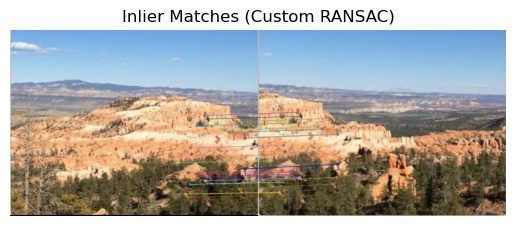

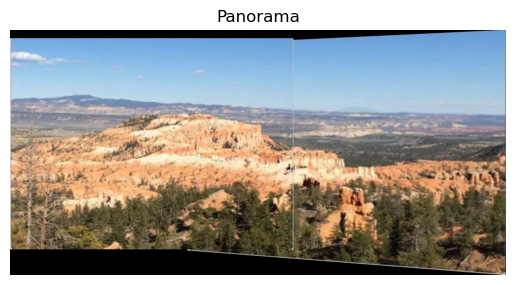

In [13]:
#IMG1_PATH = ROOT_DIR + 'B_original_image_left.jpg'   # change to your image 1
#IMG2_PATH = ROOT_DIR + 'B_original_image_right.jpg'  # change to your image 2

IMG1_PATH = ROOT_DIR + 'algn_test1_A.png'   # change to your image 1
IMG2_PATH = ROOT_DIR + 'algn_test1_B.png' 

img1 = cv2.imread(IMG1_PATH, cv2.IMREAD_COLOR)
img2 = cv2.imread(IMG2_PATH, cv2.IMREAD_COLOR)
if img1 is None or img2 is None:
    raise FileNotFoundError('Cannot open input images. Please set IMG1_PATH and IMG2_PATH correctly.')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect keypoints
kps1 = detect_keypoints_dog_harris(gray1)
kps2 = detect_keypoints_dog_harris(gray2)
print(f'Keypoints: img1={len(kps1)}, img2={len(kps2)}')
cv2.imwrite(str(OUT_DIR/'kps_img1.png'), draw_keypoints(img1, kps1))
cv2.imwrite(str(OUT_DIR/'kps_img2.png'), draw_keypoints(img2, kps2))

# ORB descriptors
kps1_cv, desc1 = compute_orb_descriptors(gray1, kps1)
kps2_cv, desc2 = compute_orb_descriptors(gray2, kps2)
if desc1 is None or desc2 is None:
    raise RuntimeError('No descriptors computed; try relaxing thresholds or pick more textured images.')

# Matching (ratio test)
good = match_descriptors(desc1, desc2, ratio=0.75)
print('Good matches:', len(good))
matches_all = cv2.drawMatches(img1, kps1_cv, img2, kps2_cv, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite(str(OUT_DIR/'matches_all.png'), matches_all)

# Custom Homography
H, inliers = estimate_homography_custom(kps1_cv, kps2_cv, good, ransac_thresh=3.0)
if H is None:
    raise RuntimeError('Custom homography estimation failed (not enough inliers).')
print('Homography (custom):\n', H)
inlier_matches = [m for m, keep in zip(good, inliers) if keep]
matches_inliers = cv2.drawMatches(img1, kps1_cv, img2, kps2_cv, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite(str(OUT_DIR/'matches_inliers.png'), matches_inliers)

# Warp & panorama
warped_img2, panorama = warp_and_stitch(img1, img2, H)
cv2.imwrite(str(OUT_DIR/'warped_img2.png'), warped_img2)
cv2.imwrite(str(OUT_DIR/'panorama.png'), panorama)

# Show quick previews
plt.figure(); plt.imshow(cv2.cvtColor(matches_inliers, cv2.COLOR_BGR2RGB)); plt.title('Inlier Matches (Custom RANSAC)'); plt.axis('off'); plt.show()
plt.figure(); plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)); plt.title('Panorama'); plt.axis('off'); plt.show()

### Tips
- If you get few inliers, try lowering `CONTRAST_TH`/`HARRIS_REL_TH`, increase overlap, or set `ransac_thresh=5.0`.
- For very large images, consider resizing to ~1500px width for speed.